# Post-scVI analysis of all donors data (nuclei and cells), only trophoblast

V4 - final manifold calculation after inv troph annotation thoughout notebooks S1-1; S1-2 and S1-3 and disregarding 'rest' class inferred in notebook S0-3

After doublets removal (both by genotype and GEX)

This the version of the manifold after running scVI by `sample` and removing genes that have been filtered according to high ambient RNA in notebook **M2**

11.11.2021

What happens here:
- load preprocessed object (raw filtered counts)
- do normalising & log transforming
- save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- calculate neighborhood graph on the latent dimensionality reporesentation from scVI
- umap
- unbiased clustering
- save

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
import bbknn
import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
annoy               NA
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bbknn               NA
brotli              NA
cairo               1.20.0
certifi             2021.10.08
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyte

In [4]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202111_MFI_sc_sn_new_scVI_analysis/'

## Reading the preprocessed object

Preprocessing happened in M0 notebook

In [5]:
# reading the raw filtered object from joint analysis
adata = sc.read(save_path + 'adata_raw_filtered.h5ad')

In [6]:
# reading IDs of final cells to keep after doublet exclusion (scrublet and souporcell)
nodoublet_IDs = pd.read_csv(save_path + 'selected_droplets_no_doublets_in_M1_prelim_analysis.csv', index_col=0)
nodoublet_IDs

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


n_genes            sample  \
barcode_sample                                                   
AAACGGGCATTGGCGC-1_FCA7167219           1941        FCA7167219   
AAACGGGTCGCGATCG-1_FCA7167219           1246        FCA7167219   
AAAGATGAGCAATATG-1_FCA7167219           1516        FCA7167219   
AAAGATGAGTTCGCGC-1_FCA7167219           2099        FCA7167219   
AAAGATGCATGTCGAT-1_FCA7167219           1636        FCA7167219   
...                                      ...               ...   
TTTGTGTTCGTCAAGT-1_Pla_Camb10714920     2409  Pla_Camb10714920   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920     4129  Pla_Camb10714920   
TTTGTTGGTCACAGCG-1_Pla_Camb10714920     3116  Pla_Camb10714920   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920     3696  Pla_Camb10714920   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920     2130  Pla_Camb10714920   

                                           technology  \
barcode_sample                                          
AAACGGGCATTGGCGC-1_FCA7167219        10X_3'_scRNA-seq   
AAACGGGTCGCGATCG-1_FCA7167219        10X_3'_scRNA-seq   
AAAGATGAGCAATATG-1_FCA7167219        10X_3'_scRNA-seq   
AAAGATGAGTTCGCGC-1_FCA7167219        10X_3'_scRNA-seq   
AAAGATGCATGTCGAT-1_FCA7167219        10X_3'_scRNA-seq   
...                                               ...   
TTTGTGTTCGTCAAGT-1_Pla_Camb10714920      10X_multiome   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920      10X_multiome   
TTTGTTGGTCACAGCG-1_Pla_Camb10714920      10X_multiome   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920      10X_multiome   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920      10X_multiome   

                                                          tissue  dev_age  \
barcode_sample                                                              
AAACGGGCATTGGCGC-1_FCA7167219                     decidua_immune   13_PCW   
AAACGGGTCGCGATCG-1_FCA7167219                     decidua_immune   13_PCW   
AAAGATGAGCAATATG-1_FCA7167219                     decidua_immune   13_PCW   
AAAGATGAGTTCGCGC-1_FCA7167219                     decidua_immune   13_PCW   
AAAGATGCATGTCGAT-1_FCA7167219                     decidua_immune   13_PCW   
...                                                          ...      ...   
TTTGTGTTCGTCAAGT-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   
TTTGTTGGTCACAGCG-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   

                                    donor               dataset  run  \
barcode_sample                                                         
AAACGGGCATTGGCGC-1_FCA7167219           6          Vento_Nature  NaN   
AAACGGGTCGCGATCG-1_FCA7167219           6          Vento_Nature  NaN   
AAAGATGAGCAATATG-1_FCA7167219           6          Vento_Nature  NaN   
AAAGATGAGTTCGCGC-1_FCA7167219           6          Vento_Nature  NaN   
AAAGATGCATGTCGAT-1_FCA7167219           6          Vento_Nature  NaN   
...                                   ...                   ...  ...   
TTTGTGTTCGTCAAGT-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   
TTTGTTGGTCACAGCG-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   

                                     number_of_individuals_multiplexed  batch  \
barcode_sample                                                                  
AAACGGGCATTGGCGC-1_FCA7167219                                        1      0   
AAACGGGTCGCGATCG-1_FCA7167219                                        1      0   
AAAGATGAGCAATATG-1_FCA7167219                                        1      0   
AAAGATGAGTTCGCGC-1_FCA7167219                                        1      0   
AAAGATGCATG

In [7]:
# subsetting the adata object to final cells
adata = adata[list(nodoublet_IDs.index), :].copy()
adata

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 378558 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-19', 'feature_types-1

In [8]:
# adding metadata
for col in nodoublet_IDs.columns:
    print(col)
    adata.obs[col] = nodoublet_IDs.loc[adata.obs_names,col]

n_genes
sample
technology
tissue
dev_age
donor
dataset
run
number_of_individuals_multiplexed
batch
percent_mito
n_counts
scrublet_score
scrublet_cluster_score
bh_pval
is_doublet
celltype_predictions
probabilities
barcode_sample_copy
souporcell_assignment
inter_ind_doublet
S_score
G2M_score
phase
origin_M_F
is_doublet_0.05
is_doublet_0.01


In [9]:
np.unique(adata.obs['sample'])

array(['FCA7167219', 'FCA7167221', 'FCA7167222', 'FCA7167223',
       'FCA7167224', 'FCA7167226', 'FCA7167230', 'FCA7167231',
       'FCA7167232', 'FCA7196218', 'FCA7196219', 'FCA7196220',
       'FCA7196224', 'FCA7196225', 'FCA7196226', 'FCA7196229',
       'FCA7196231', 'FCA7474062', 'FCA7474063', 'FCA7474064',
       'FCA7474065', 'FCA7474066', 'FCA7474068', 'FCA7474069',
       'FCA7511881', 'FCA7511882', 'FCA7511883', 'FCA7511884',
       'FCA7511885', 'FCA7511886', 'Pla_Camb10691970', 'Pla_Camb10691971',
       'Pla_Camb10691972', 'Pla_Camb10691975', 'Pla_Camb10714918',
       'Pla_Camb10714919', 'Pla_Camb10714920', 'Pla_HDBR10142767',
       'Pla_HDBR10142768', 'Pla_HDBR10142769', 'Pla_HDBR10142770',
       'Pla_HDBR10142863', 'Pla_HDBR10142864', 'Pla_HDBR10142865',
       'Pla_HDBR10701666', 'Pla_HDBR10701667', 'Pla_HDBR10701668',
       'Pla_HDBR10917730', 'Pla_HDBR10917731', 'Pla_HDBR10917733',
       'Pla_HDBR8624430', 'Pla_HDBR8624431', 'Pla_HDBR8715512',
       'Pla_HDBR87

In [10]:
# quick check to see if raw is raw or not
expr_mtx_dense = adata[adata.obs['sample'] == 'Pla_Camb10691970'].X.todense()

In [11]:
# YAS we all good
np.unique(expr_mtx_dense)

matrix([[   0.,    0.,    0., ..., 4162., 4637., 6366.]], dtype=float32)

In [15]:
# subsetting to only final trophoblast
annot_troph = pd.read_csv(save_path + 'obs_table_all_troph_v3_prelim_annot.csv',
                          index_col=0)
adata = adata[annot_troph.index,:].copy()
adata.obs['annot_troph'] = annot_troph.loc[adata.obs_names,'annot_troph']
adata.obs['annot_troph'].value_counts()

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


SCT           28177
VCT           23470
VCT_p          6679
EVT_1          5286
iEVT           3639
VCT_CCC        3373
EVT_2          2347
VCT_fusing     1971
rest            813
GC               72
eEVT             28
Name: annot_troph, dtype: int64

In [16]:
adata

AnnData object with n_obs × n_vars = 75855 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_troph'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

In [17]:
adata = adata[adata.obs['annot_troph'] != 'rest'].copy()
adata

AnnData object with n_obs × n_vars = 75042 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_troph'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

________

In [18]:
# for scVI using n_latent=5 and no CCG filtering

________

Carrying on to 
- Normalise and log transform
- Save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- Make cell names (obs) and gene names (var) unique

In [19]:
# normalise and log transform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

# saving normalised and log transformed values into the raw attribute to later be able to plot
adata.raw = adata.copy()

adata.var_names_make_unique()
adata.obs_names_make_unique()

normalizing by total count per cell
    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


_____________________________________________________________________________________________________________________________________________________________

In [20]:
# Assign cell cycle stage & scores
cell_cycle_genes = [x.strip() for x in open(file='/home/jovyan/notebooks/Vento_Lab/regev_lab_cell_cycle_genes_from_Luz_20200505.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    420 total control genes are used. (0:00:03)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    378 total control genes are used. (0:00:03)
-->     'phase', cell cycle phase (adata.obs)


In [21]:
adata

AnnData object with n_obs × n_vars = 75042 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_troph'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

_______________________________________________________________________________________________________

# Read in scVI-calculated latent representation

In [22]:
# in this case we only used 5 PCs, but also experimented with the layers
n_latent = [5]
n_layers = [3]

### 14.11.2021 run, correction by `sample`

In [23]:
latent_representations = {}

for n_layers_value in n_layers:
    print(n_layers_value)
    
    curr_path = '/nfs/team292/aa22/scVI_related/202111_upd_in_vivo_analysis/all_donors_analysis/results/20211114_obsm_with_scVI_latent_representation_n_5_after_all_doublet_exclusion_by_sample_Trophoblast_compartment_v4_final_with_LF_gene_filter_n_layers_' + str(n_layers_value) + '.csv' 
        
    latent_representations[n_layers_value] = pd.read_csv(curr_path, index_col=0)

3


In [24]:
# assign these latent_representations into adata.obsm
for n_layers_value in n_layers:
    print(n_layers_value)
    adata.obsm['X_scVI_n_latent_5_sample_n_layers_' + str(n_layers_value) + '_gf_v4'] = np.array(latent_representations[n_layers_value])
    

3


In [25]:
adata.obsm['X_scVI_n_latent_5_sample_n_layers_3_gf_v4'].shape

(75042, 5)

__________________________________________________________________________________________________________________________________________________________________

### Neighbourhood graph & UMAP

In [26]:
%%time

for n_layers_value in n_layers:
    print(n_layers_value)
    sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_scVI_n_latent_5_sample_n_layers_' + str(n_layers_value) + '_gf_v4',
               key_added='neighbors_scVI_n_latent_5_sample_n_layers_' + str(n_layers_value) + '_gf_v4')

computing neighbors


3


    finished: added to `.uns['neighbors_scVI_n_latent_5_sample_n_layers_3_gf_v4']`
    `.obsp['neighbors_scVI_n_latent_5_sample_n_layers_3_gf_v4_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_scVI_n_latent_5_sample_n_layers_3_gf_v4_connectivities']`, weighted adjacency matrix (0:00:19)


CPU times: user 25 s, sys: 21.5 s, total: 46.5 s
Wall time: 19.9 s


In [27]:
adata

AnnData object with n_obs × n_vars = 75042 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_troph'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

__________________________________________________________________________________________________________________________________________________________________

In [28]:
%%time
# takes a few minutes
for n_layers_value in n_layers:
    print(n_layers_value)
    
    sc.tl.umap(adata, random_state=0,
              neighbors_key='neighbors_scVI_n_latent_5_sample_n_layers_' + str(n_layers_value) + '_gf_v4')
    # copy current adata.obsm['X_umap'] into adata.obsm['X_umap_scVI_n_latent_' + str(n_latent_value)]
    adata.obsm['X_umap_scVI_n_latent_5_sample_n_layers_' + str(n_layers_value) + '_gf_v4'] = adata.obsm['X_umap']
    
    

computing UMAP


3


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)


CPU times: user 1min 10s, sys: 31.7 s, total: 1min 42s
Wall time: 29.8 s


In [29]:
np.unique(adata.obs['sample'], return_counts=True)

(array(['FCA7167219', 'FCA7167221', 'FCA7167222', 'FCA7167223',
        'FCA7167224', 'FCA7167226', 'FCA7196218', 'FCA7196219',
        'FCA7196220', 'FCA7196224', 'FCA7196225', 'FCA7196226',
        'FCA7474062', 'FCA7474063', 'FCA7474064', 'FCA7474065',
        'FCA7474066', 'FCA7474068', 'FCA7474069', 'FCA7511881',
        'FCA7511882', 'FCA7511883', 'FCA7511884', 'FCA7511885',
        'FCA7511886', 'Pla_Camb10691970', 'Pla_Camb10691971',
        'Pla_Camb10691972', 'Pla_Camb10691975', 'Pla_Camb10714918',
        'Pla_Camb10714919', 'Pla_Camb10714920', 'Pla_HDBR10142767',
        'Pla_HDBR10142768', 'Pla_HDBR10142769', 'Pla_HDBR10142770',
        'Pla_HDBR10142863', 'Pla_HDBR10142864', 'Pla_HDBR10142865',
        'Pla_HDBR10701666', 'Pla_HDBR10701667', 'Pla_HDBR10701668',
        'Pla_HDBR10917730', 'Pla_HDBR10917731', 'Pla_HDBR10917733',
        'Pla_HDBR8624430', 'Pla_HDBR8624431', 'Pla_HDBR8715512',
        'Pla_HDBR8715514', 'Pla_HDBR8768477', 'WSSS_PLA8764121',
        'WSSS_PL

In [30]:
adata

AnnData object with n_obs × n_vars = 75042 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_troph'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

## Saving this object with all the manifolds calculated

In [31]:
adata.write(save_path + 'adata_scVI_analysed_corr_by_sample_Trophoblast_v4_final_with_LF_gene_filter.h5ad')


... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'tissue' as categorical
... storing 'dev_age' as categorical
... storing 'donor' as categorical
... storing 'dataset' as categorical
... storing 'celltype_predictions' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'phase' as categorical
... storing 'origin_M_F' as categorical
... storing 'annot_troph' as categorical


In [5]:
# reading the previously saved file
adata = sc.read(save_path + 'adata_scVI_analysed_corr_by_sample_Trophoblast_v4_final_with_LF_gene_filter.h5ad')


In [8]:
# to better distinguish predictions from Vento-Tormo dataset
colors_VT = ['#C1B4A7','#E8D6E0','#40ab5d','#F4BF73','#F7B5A4',
                 '#d8e7a4','#2ECCFA','#39728C','#FA5858','#E9A1C7',
                 '#B40486','#004529','#C49A6C','#9255a0', '#58595B', '#A3A8AD',
                 '#F6D8CE','#633A6D','#C7E0BD','#49ABC8', '#E7C949', '#F7F297', '#af9e56',
                 '#ED1B64','#E59C24','#C2E8F6','#677EB2','#73FDD6', '#BC3122', '#771A15',
                 '#E6C6F7','#CEE3F6','#CECEF6','#677EB2','#6363A5','#63A585',
                 '#246D66','#9B8579']

### scVI-corrected by `sample`

n_latent = 5, n_layers = 3

In [11]:
curr_embedding_key = 'X_umap_scVI_n_latent_5_sample_n_layers_3_gf_v4'

Trying to set attribute `.uns` of view, copying.


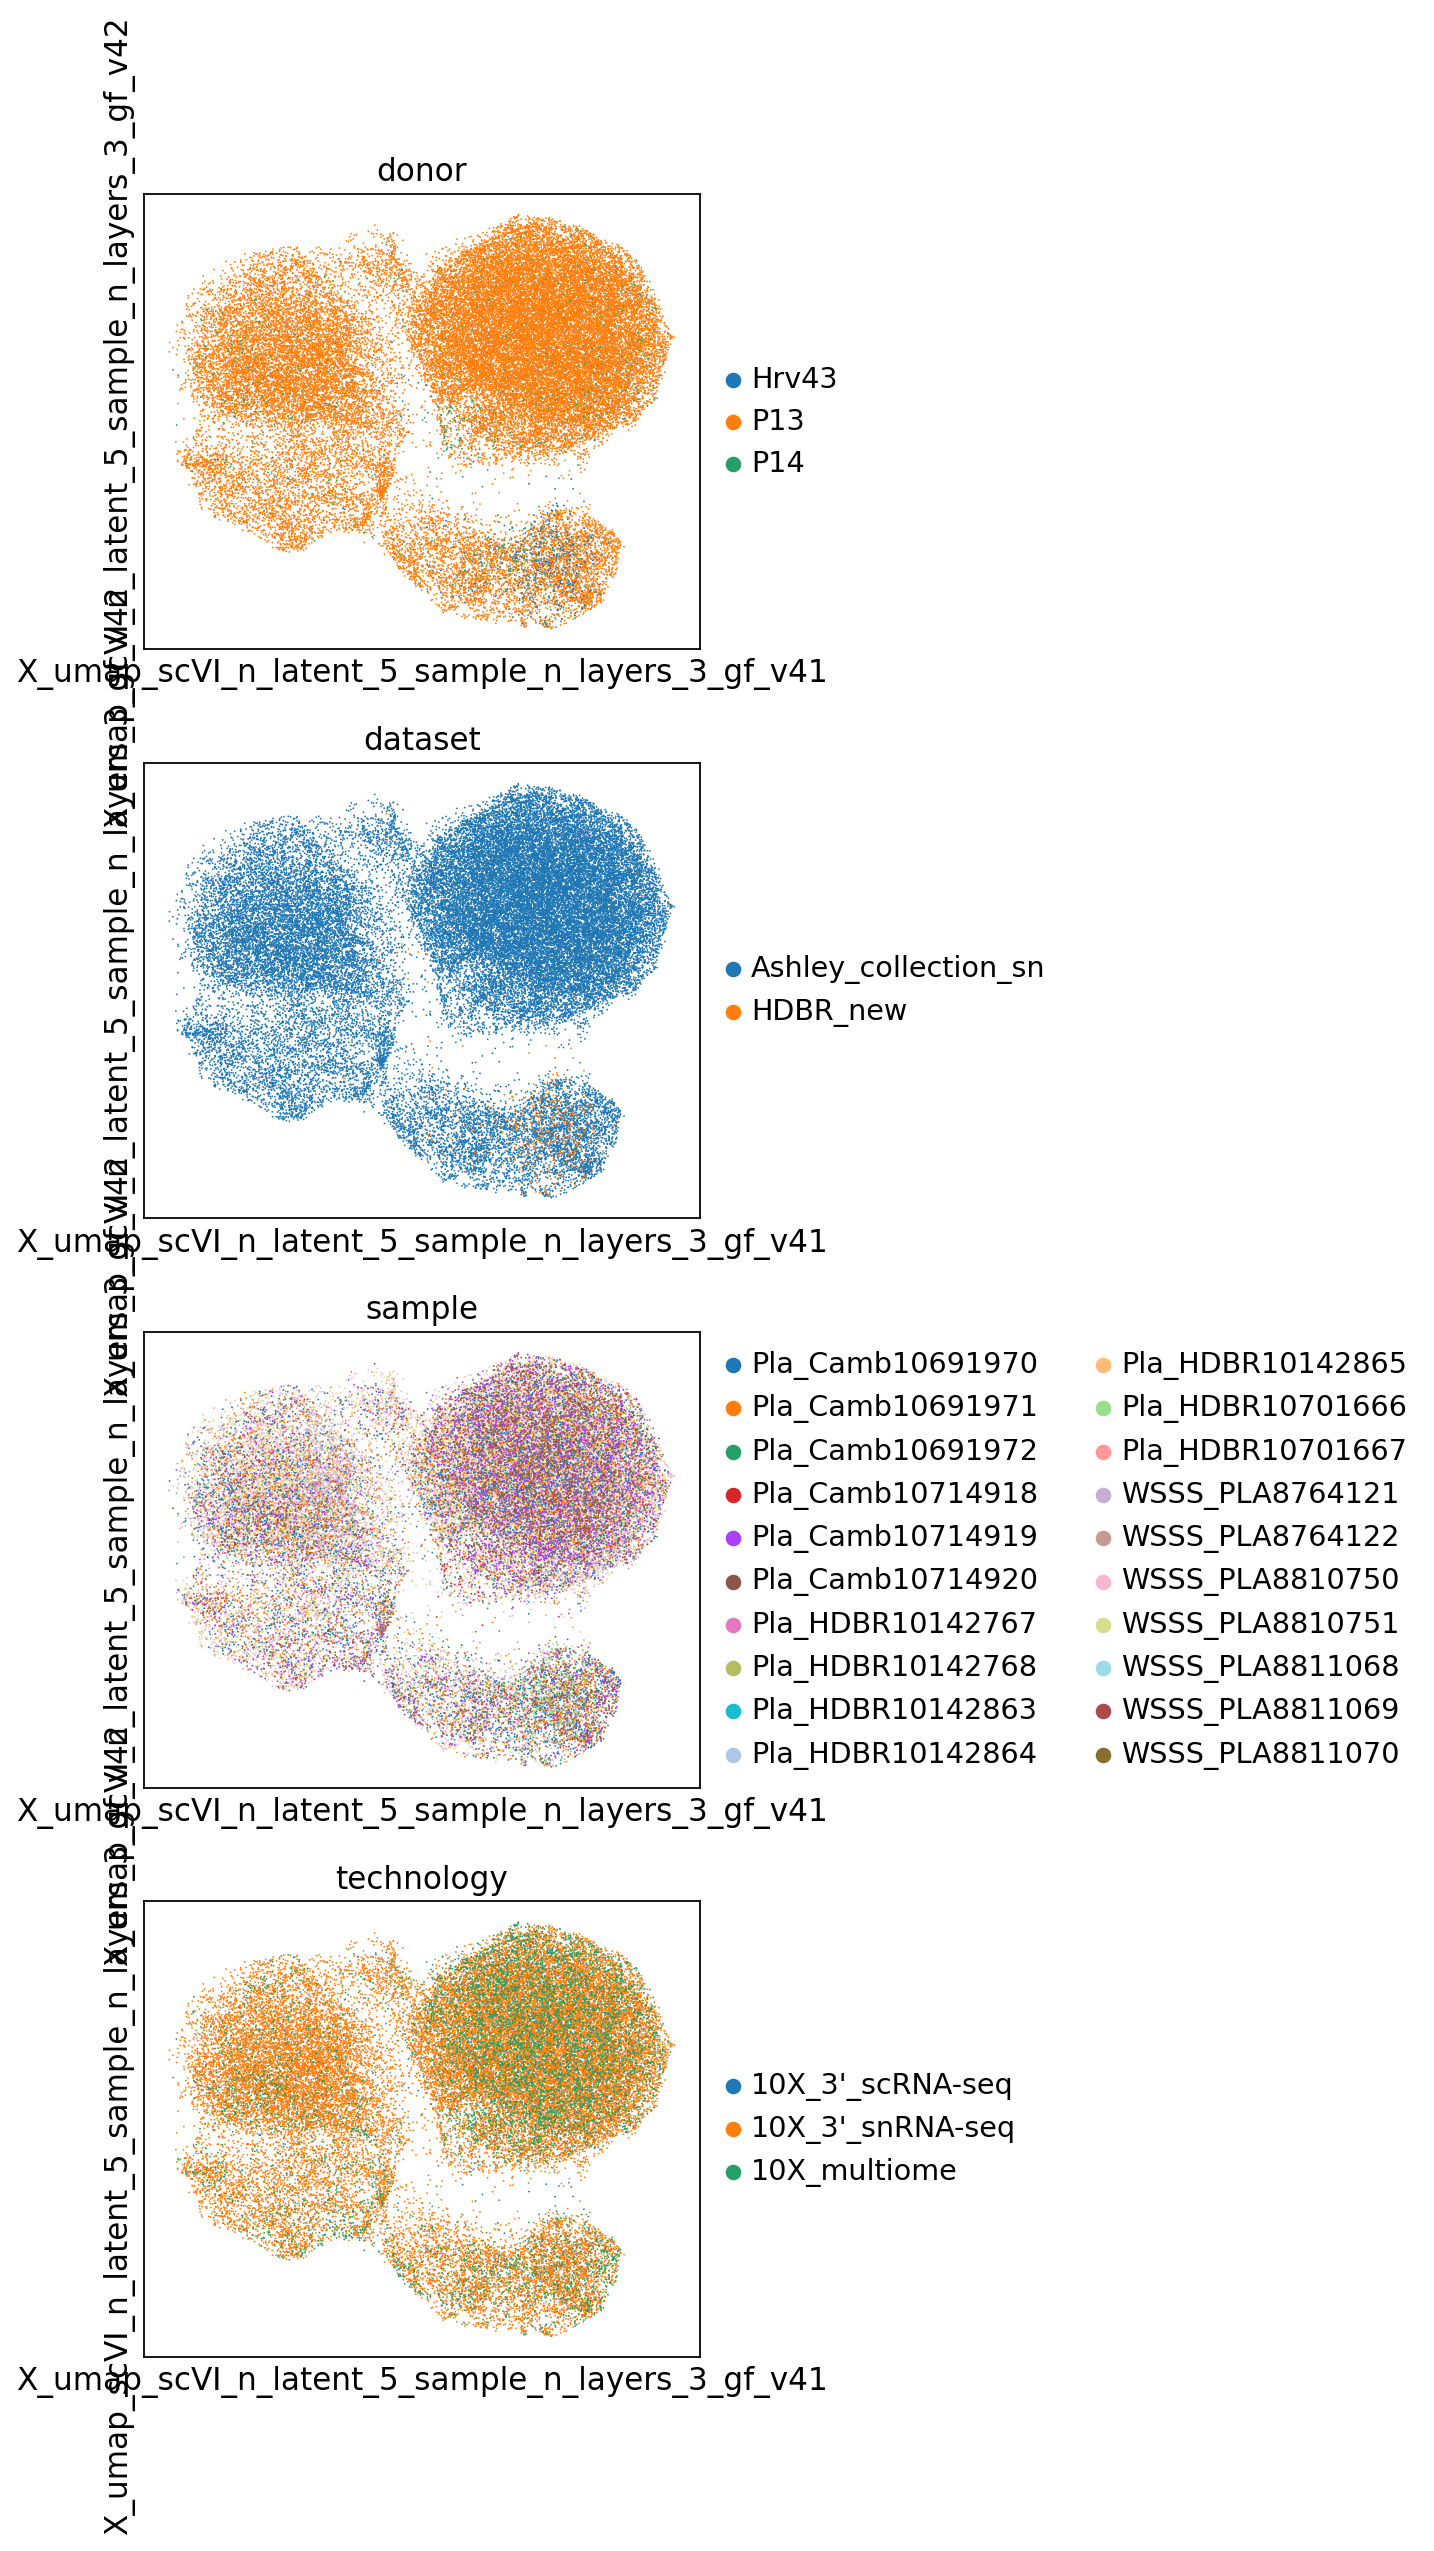

In [8]:
sc.pl.embedding(adata[adata.obs['donor'].isin(['P13','P14','Hrv43'])], curr_embedding_key,
                color=['donor','dataset','sample','technology'], ncols=1)

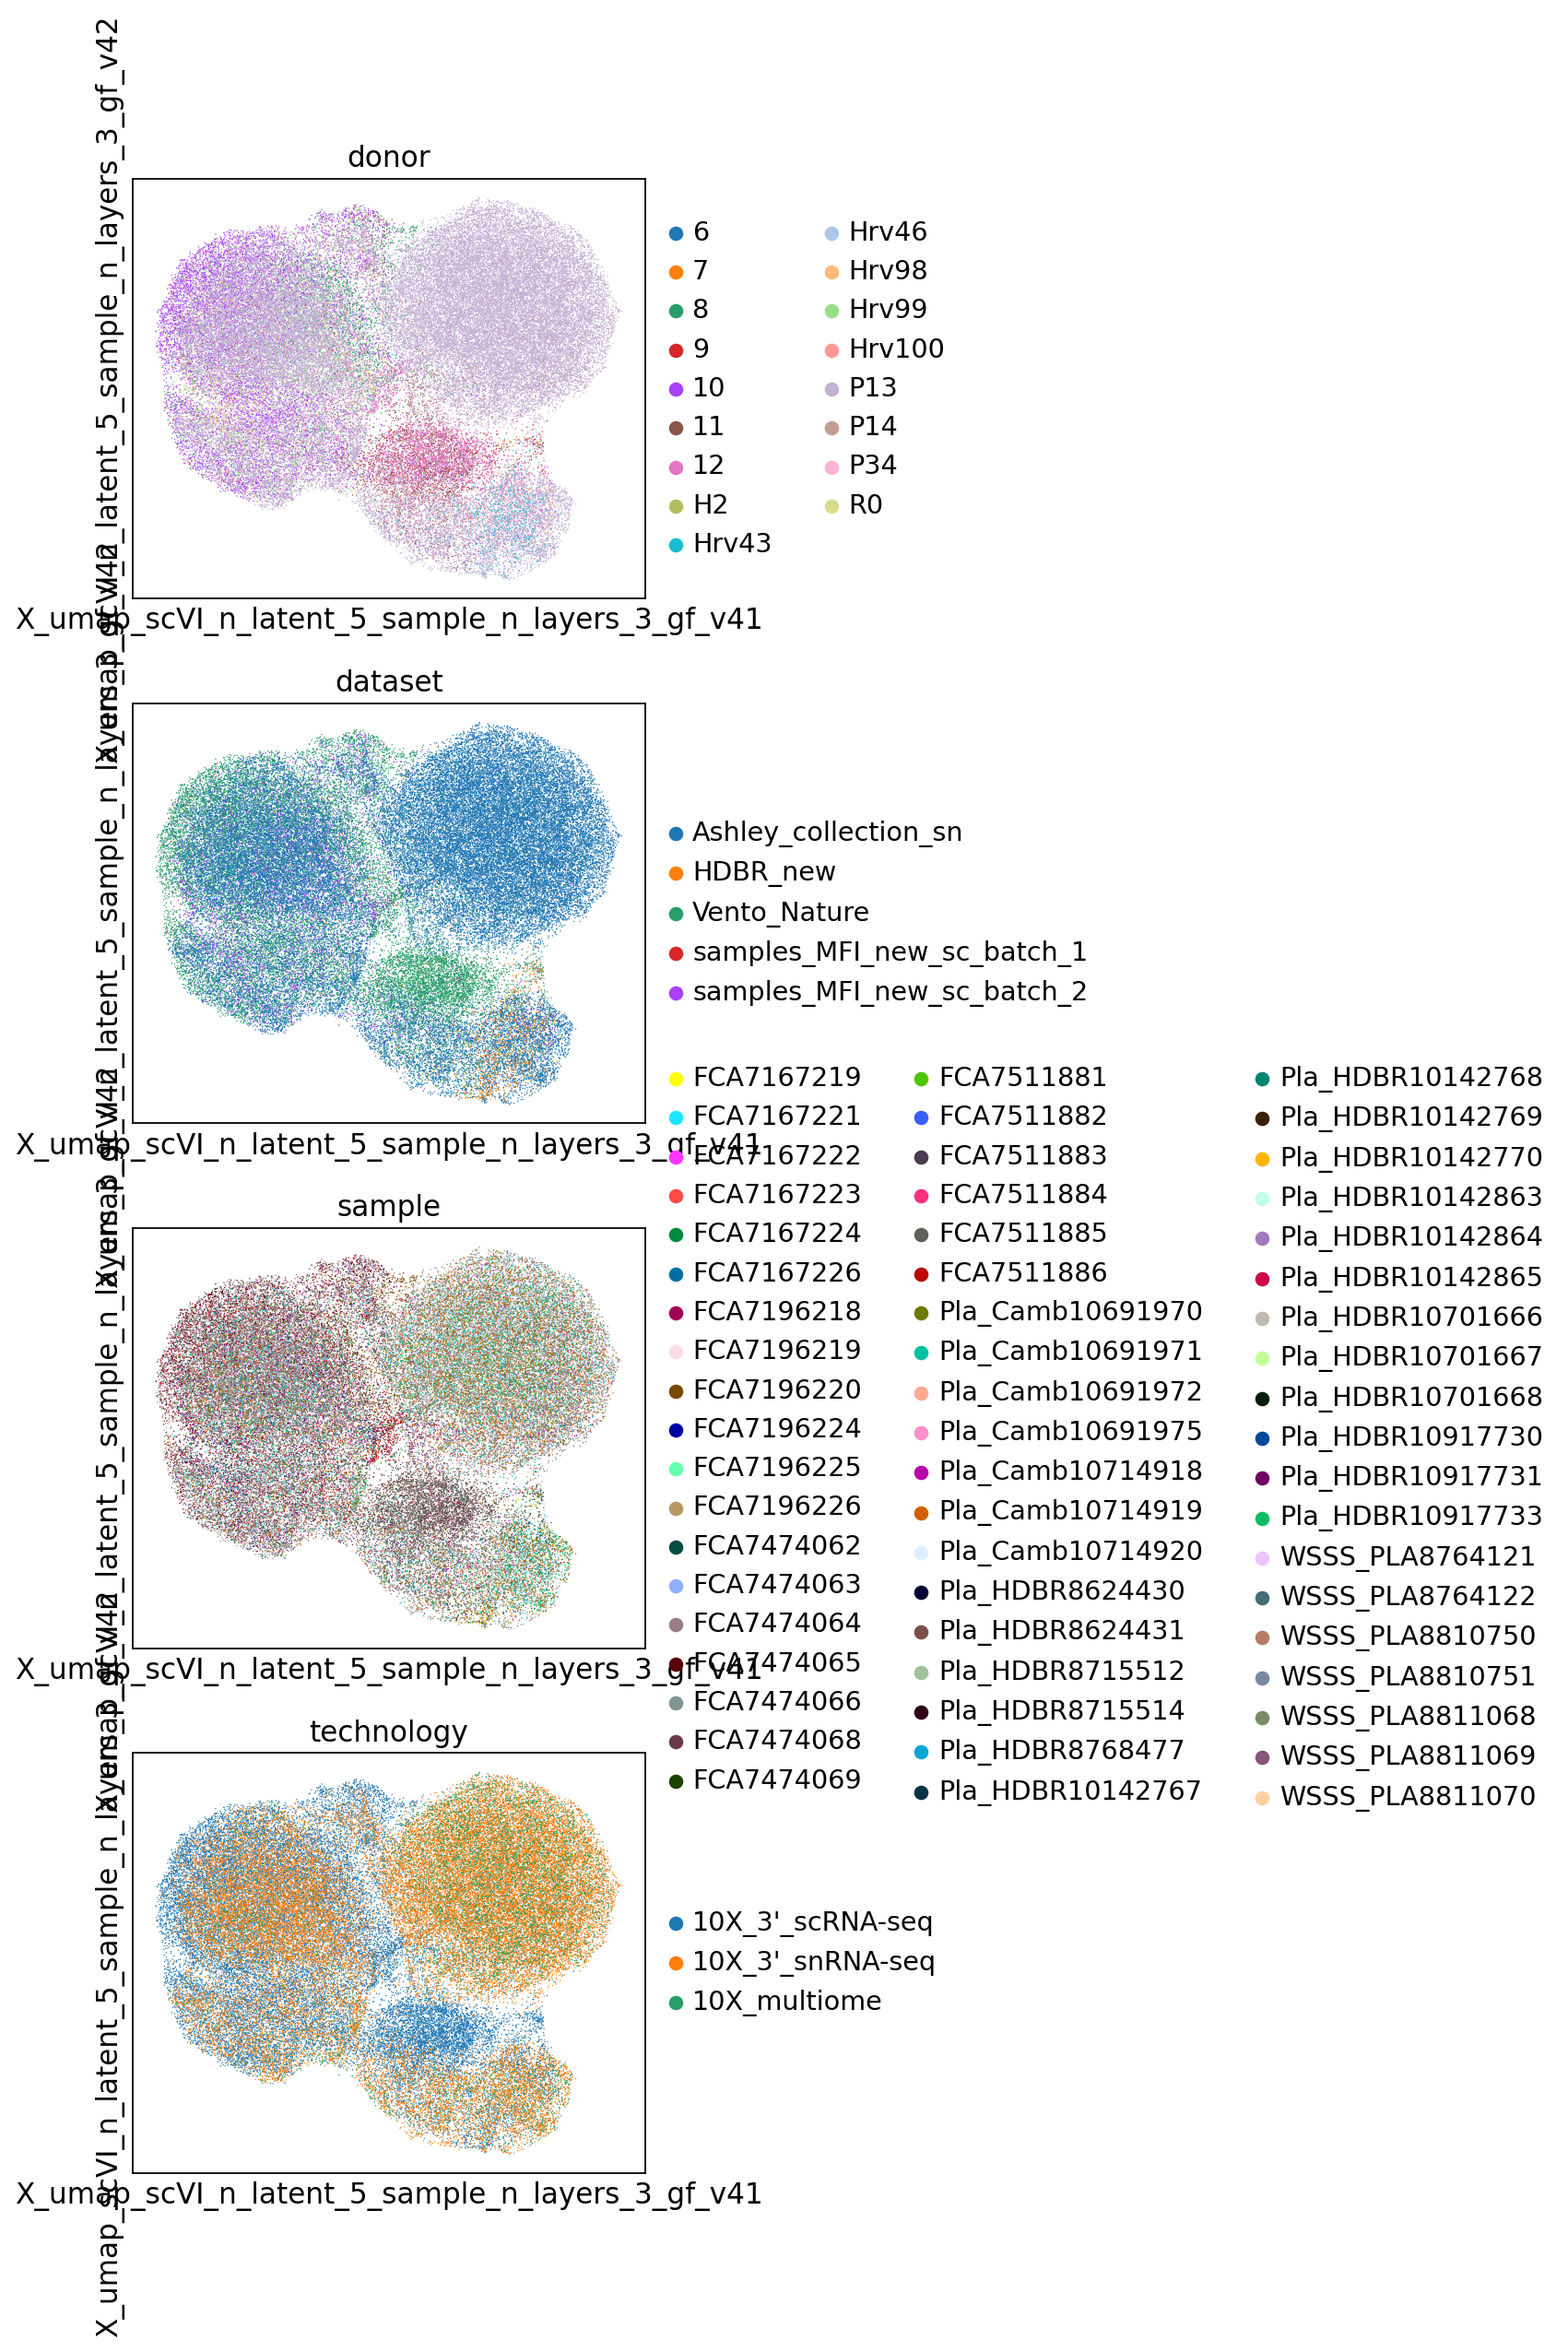

In [33]:
sc.pl.embedding(adata, curr_embedding_key,
                color=['donor','dataset','sample','technology'], ncols=1)

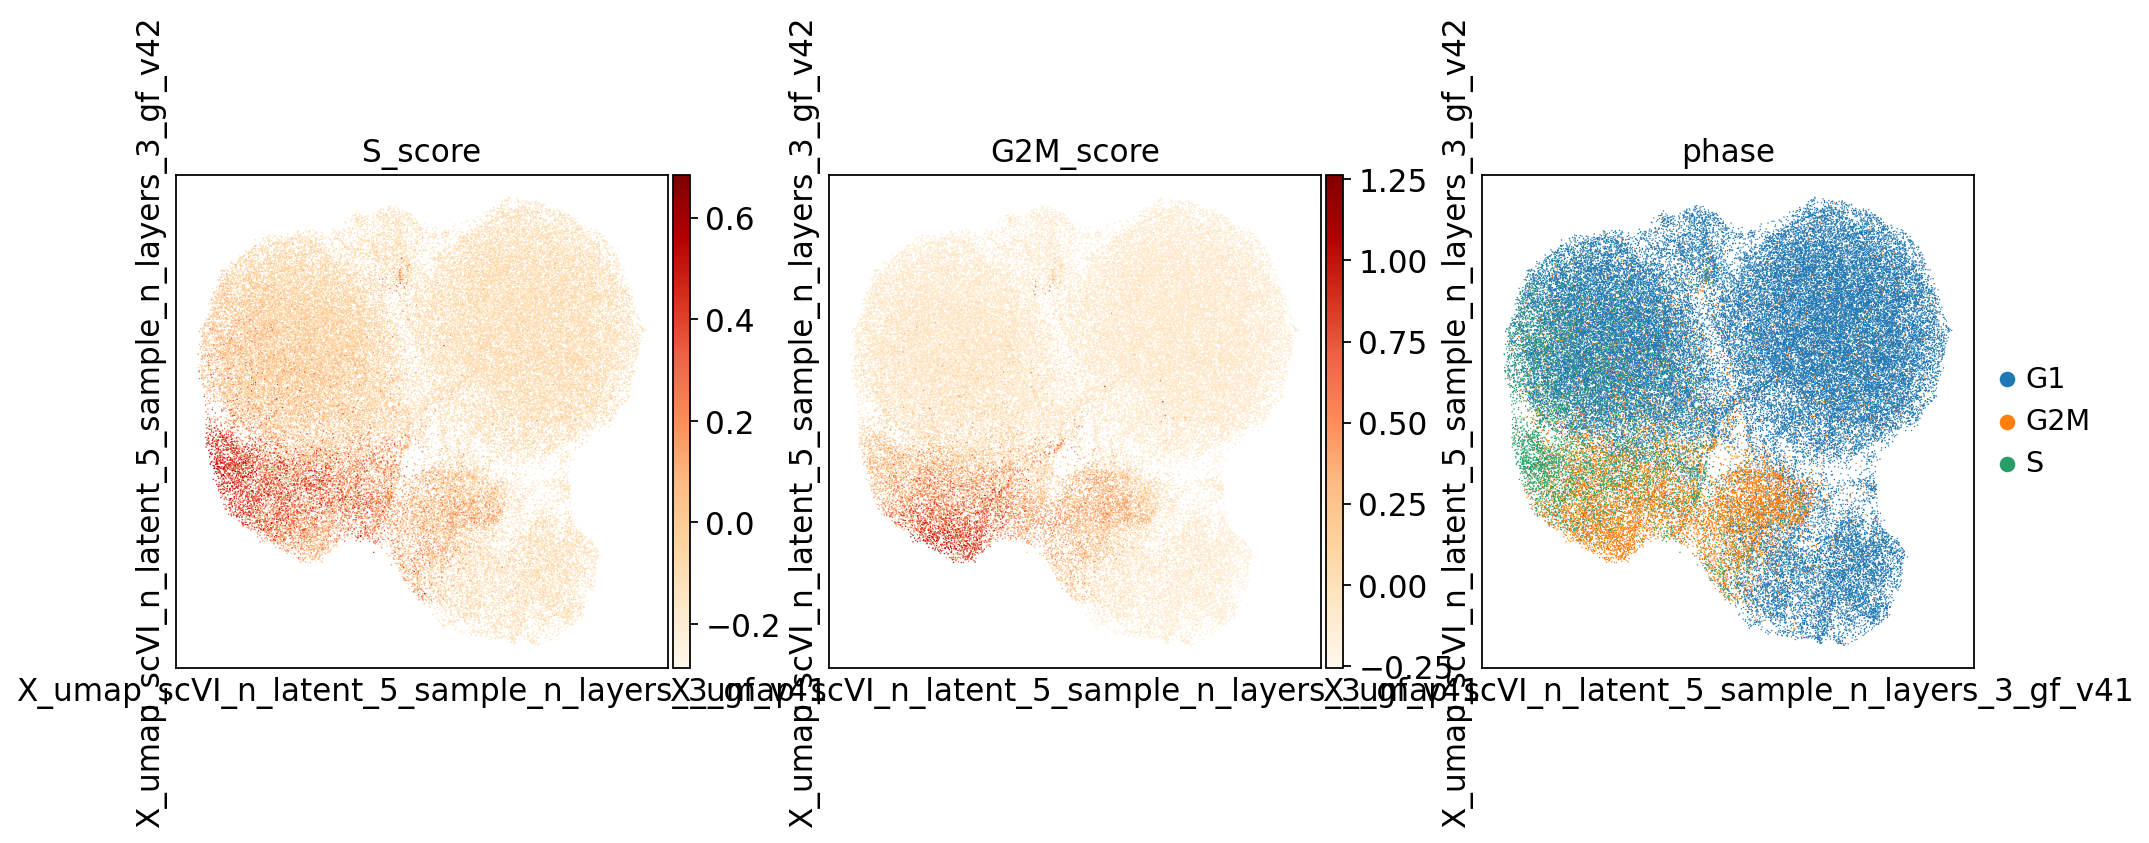

In [35]:
sc.pl.embedding(adata, curr_embedding_key,
                color=['S_score','G2M_score','phase'], cmap='OrRd')

In [6]:
# add final labels
final_annot = pd.read_csv(save_path + 'obs_table_all_troph_v3_prelim_annot.csv', index_col=0)

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
len(adata)

75042

In [8]:
len(set(adata.obs.index) & set(final_annot.index))

75042

In [10]:
final_annot

n_genes            sample  \
barcode_sample                                                   
AGGGTGAGTAAAGGAG-1_FCA7167219           5291        FCA7167219   
CTGATAGAGCCCAGCT-1_FCA7167219           4070        FCA7167219   
GCGCGATAGATATGGT-1_FCA7167219            506        FCA7167219   
ATTACTCTCTGCGGCA-1_FCA7167221            655        FCA7167221   
CTGATAGAGCCCAGCT-1_FCA7167221            412        FCA7167221   
...                                      ...               ...   
TTTGTGGCATGGCCTG-1_Pla_Camb10714920     4195  Pla_Camb10714920   
TTTGTGTTCGCTCACT-1_Pla_Camb10714920     1629  Pla_Camb10714920   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920     4129  Pla_Camb10714920   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920     3696  Pla_Camb10714920   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920     2130  Pla_Camb10714920   

                                           technology  \
barcode_sample                                          
AGGGTGAGTAAAGGAG-1_FCA7167219        10X_3'_scRNA-seq   
CTGATAGAGCCCAGCT-1_FCA7167219        10X_3'_scRNA-seq   
GCGCGATAGATATGGT-1_FCA7167219        10X_3'_scRNA-seq   
ATTACTCTCTGCGGCA-1_FCA7167221        10X_3'_scRNA-seq   
CTGATAGAGCCCAGCT-1_FCA7167221        10X_3'_scRNA-seq   
...                                               ...   
TTTGTGGCATGGCCTG-1_Pla_Camb10714920      10X_multiome   
TTTGTGTTCGCTCACT-1_Pla_Camb10714920      10X_multiome   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920      10X_multiome   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920      10X_multiome   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920      10X_multiome   

                                                          tissue  dev_age  \
barcode_sample                                                              
AGGGTGAGTAAAGGAG-1_FCA7167219                     decidua_immune   13_PCW   
CTGATAGAGCCCAGCT-1_FCA7167219                     decidua_immune   13_PCW   
GCGCGATAGATATGGT-1_FCA7167219                     decidua_immune   13_PCW   
ATTACTCTCTGCGGCA-1_FCA7167221                     decidua_immune   11_PCW   
CTGATAGAGCCCAGCT-1_FCA7167221                     decidua_immune   11_PCW   
...                                                          ...      ...   
TTTGTGGCATGGCCTG-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   
TTTGTGTTCGCTCACT-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   

                                    donor               dataset  run  \
barcode_sample                                                         
AGGGTGAGTAAAGGAG-1_FCA7167219           6          Vento_Nature  NaN   
CTGATAGAGCCCAGCT-1_FCA7167219           6          Vento_Nature  NaN   
GCGCGATAGATATGGT-1_FCA7167219           6          Vento_Nature  NaN   
ATTACTCTCTGCGGCA-1_FCA7167221           7          Vento_Nature  NaN   
CTGATAGAGCCCAGCT-1_FCA7167221           7          Vento_Nature  NaN   
...                                   ...                   ...  ...   
TTTGTGGCATGGCCTG-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   
TTTGTGTTCGCTCACT-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   

                                     number_of_individuals_multiplexed  batch  \
barcode_sample                                                                  
AGGGTGAGTAAAGGAG-1_FCA7167219                                        1      0   
CTGATAGAGCCCAGCT-1_FCA7167219                                        1      0   
GCGCGATAGATATGGT-1_FCA7167219                                        1      0   
ATTACTCTCTGCGGCA-1_FCA7167221                                        1      1   
CTGATAGAGCC

In [9]:
adata.obs['final_annot_troph'] = final_annot.loc[adata.obs_names,'annot_troph']

... storing 'final_annot_troph' as categorical


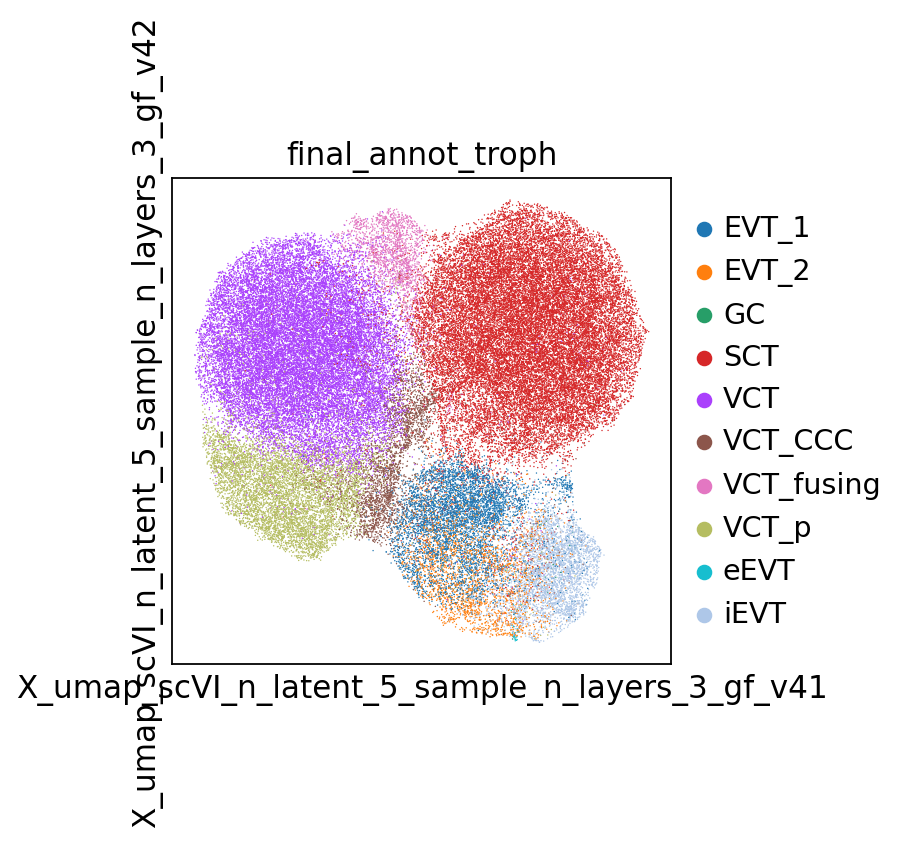

In [12]:
sc.pl.embedding(adata, curr_embedding_key,
                color=['final_annot_troph'])

... storing 'final_annot_troph' as categorical


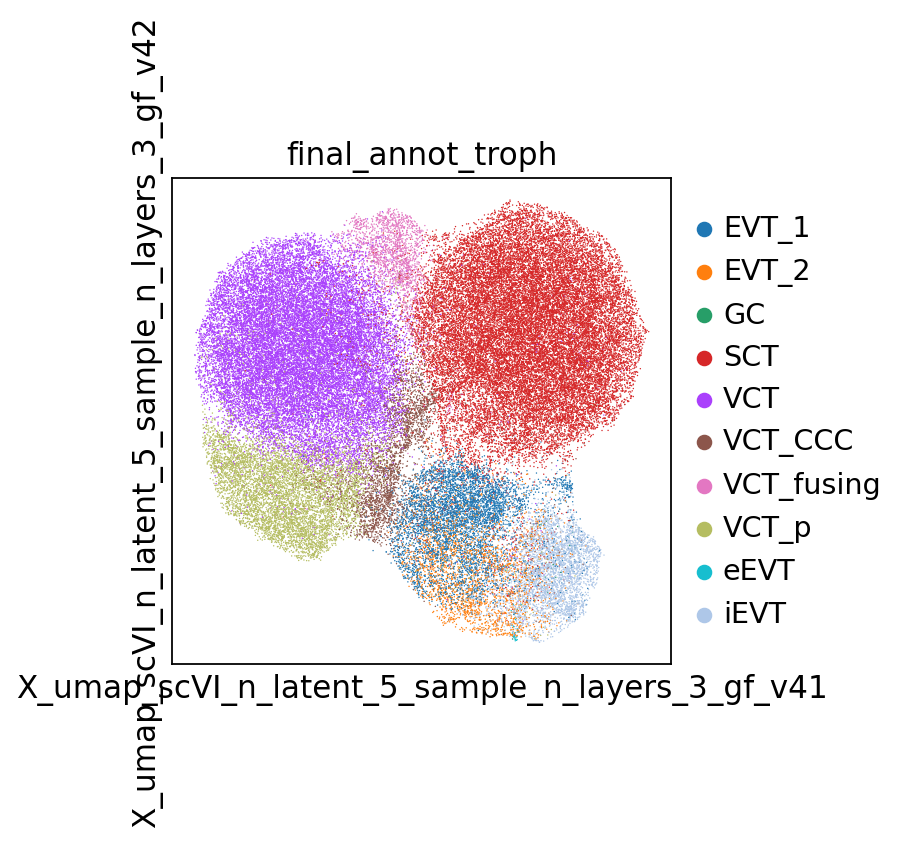

In [12]:
sc.pl.embedding(adata, curr_embedding_key,
                color=['final_annot_troph'])

In [13]:
# resave the object
adata.write(save_path + 'adata_scVI_analysed_corr_by_sample_Trophoblast_v4_final_with_LF_gene_filter.h5ad')


In [5]:
# preparing object for cellxgene/reproductivecellatlas

adata = sc.read(save_path + 'adata_scVI_analysed_corr_by_sample_Trophoblast_v4_final_with_LF_gene_filter.h5ad')


In [6]:
adata.obsm['X_umap'] = adata.obsm['X_umap_scVI_n_latent_5_sample_n_layers_3_gf_v4']

In [7]:
# saving object for cellxgene
# in this object in .X are the normalised and log tr counts for all filtered cells and genes
adata

AnnData object with n_obs × n_vars = 75042 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_troph', 'final_annot_troph'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', '

In [8]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202111_MFI_sc_sn_new_scVI_analysis/'

In [9]:
import scipy
adata.X = scipy.sparse.csc_matrix(adata.X)


In [10]:
adata.obs.columns

Index(['n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor',
       'dataset', 'run', 'number_of_individuals_multiplexed', 'batch',
       'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score',
       'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities',
       'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet',
       'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05',
       'is_doublet_0.01', 'annot_troph', 'final_annot_troph'],
      dtype='object')

In [11]:
categ_columns = ['sample', 'technology', 'tissue', 'dev_age', 'donor',
       'dataset', 'run', 'number_of_individuals_multiplexed', 'batch',
       'is_doublet', 'celltype_predictions',
       'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet',
       'phase', 'origin_M_F', 'is_doublet_0.05',
       'is_doublet_0.01', 'annot_troph', 'final_annot_troph']

cont_columns = ['n_genes', 'percent_mito',
       'n_counts', 'scrublet_score',
       'scrublet_cluster_score', 'bh_pval', 'probabilities', 'S_score', 'G2M_score']


In [12]:
for column in categ_columns:
    adata.obs[column] = pd.Categorical(adata.obs[column])
    
for column in cont_columns:
    adata.obs[column] = np.float32(adata.obs[column])

In [13]:
adata

AnnData object with n_obs × n_vars = 75042 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_troph', 'final_annot_troph'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', '

In [14]:
# removing a bunch of unnecessary metadata from .obs
adata.obs.columns

Index(['n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor',
       'dataset', 'run', 'number_of_individuals_multiplexed', 'batch',
       'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score',
       'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities',
       'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet',
       'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05',
       'is_doublet_0.01', 'annot_troph', 'final_annot_troph'],
      dtype='object')

In [15]:
cols2keep = ['n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor',
       'dataset', 'number_of_individuals_multiplexed', 'batch',
       'percent_mito', 'n_counts', 'celltype_predictions', 'probabilities',
       'S_score', 'G2M_score', 'phase', 'origin_M_F', 'final_annot_troph']
adata.obs = adata.obs.loc[:, cols2keep]

In [16]:
# to save for cellxgene/reproductivecellatlas
adata.write('/lustre/scratch117/cellgen/team292/aa22/sharing/202202_for_MFI_handover/objects_for_cellxgene_and_reproductivecellatlas/adata_all_donors_trophoblast_normlog_counts_in_X_for_visualisation.h5ad')


In [17]:
# additionally, putting actual raw counts in .raw.X
adata_raw = sc.read(save_path + 'adata_raw_filtered.h5ad')
adata_raw = adata_raw[adata.obs_names,:]

# raw values
adata.raw = adata_raw.copy()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [ ]:
# additionally saving the same object for downloading after adding raw counts into the .raw.X layer
adata.write('/lustre/scratch117/cellgen/team292/aa22/sharing/202202_for_MFI_handover/objects_for_cellxgene_and_reproductivecellatlas/adata_all_donors_trophoblast_raw_counts_in_raw_normlog_counts_in_X_for_download.h5ad')
